In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("skandasana/disease-prediction-based-on-blood-test")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/disease-prediction-based-on-blood-test


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:

import cv2
import yaml
import torch
from ultralytics import YOLO
from tqdm import tqdm
import os
import json
import shutil
from PIL import Image


In [ ]:
import os

def quick_bccd_check(bccd_root):
    """Quick check of BCCD dataset structure"""

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(bccd_root, split)
        print(f"\n📊 {split.upper()} SPLIT:")

        if not os.path.exists(split_path):
            print(f"❌ {split} directory missing")
            continue

        # Check what directories exist
        subdirs = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        print(f"📁 Subdirectories: {subdirs}")

        # Check for annotation files in each subdirectory
        for subdir in subdirs:
            subdir_path = os.path.join(split_path, subdir)
            files = os.listdir(subdir_path)[:3]  # First 3 files
            extensions = set([os.path.splitext(f)[1].lower() for f in os.listdir(subdir_path)])
            print(f"   {subdir}/: {len(os.listdir(subdir_path))} files, extensions: {extensions}")
            if files:
                print(f"      Examples: {files}")

# Replace with your actual path
bccd_root = "/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD"  # CHANGE THIS!
quick_bccd_check(bccd_root)


📊 TRAIN SPLIT:
📁 Subdirectories: ['ann', 'img']
   ann/: 205 files, extensions: {'.json'}
      Examples: ['BloodImage_00355.jpeg.json', 'BloodImage_00309.jpeg.json', 'BloodImage_00165.jpeg.json']
   img/: 205 files, extensions: {'.jpeg'}
      Examples: ['BloodImage_00198.jpeg', 'BloodImage_00100.jpeg', 'BloodImage_00039.jpeg']

📊 VAL SPLIT:
📁 Subdirectories: ['ann', 'img']
   ann/: 87 files, extensions: {'.json'}
      Examples: ['BloodImage_00130.jpeg.json', 'BloodImage_00272.jpeg.json', 'BloodImage_00014.jpeg.json']
   img/: 87 files, extensions: {'.jpeg'}
      Examples: ['BloodImage_00073.jpeg', 'BloodImage_00037.jpeg', 'BloodImage_00397.jpeg']

📊 TEST SPLIT:
📁 Subdirectories: ['ann', 'img']
   ann/: 72 files, extensions: {'.json'}
      Examples: ['BloodImage_00169.jpeg.json', 'BloodImage_00149.jpeg.json', 'BloodImage_00057.jpeg.json']
   img/: 72 files, extensions: {'.jpeg'}
      Examples: ['BloodImage_00088.jpeg', 'BloodImage_00172.jpeg', 'BloodImage_00063.jpeg']


In [ ]:
import os
import json
import shutil
from PIL import Image
from tqdm import tqdm

def debug_bccd_annotations(bccd_root, num_samples=3):
    """Debug BCCD annotations to understand the structure"""
    print("🔍 Debugging BCCD annotation structure...\n")

    for split in ['train', 'val', 'test']:
        ann_dir = os.path.join(bccd_root, split, "ann")
        if not os.path.exists(ann_dir):
            continue

        print(f"📊 {split.upper()} ANNOTATIONS:")
        ann_files = [f for f in os.listdir(ann_dir) if f.endswith('.json')]

        for i, ann_file in enumerate(ann_files[:num_samples]):
            ann_path = os.path.join(ann_dir, ann_file)
            print(f"\n📄 File: {ann_file}")

            try:
                with open(ann_path, 'r') as f:
                    data = json.load(f)

                print(f"🔑 Keys: {list(data.keys())}")

                # Check different possible annotation formats
                if 'shapes' in data:
                    shapes = data['shapes']
                    print(f"📐 Shapes found: {len(shapes)}")
                    if shapes:
                        print(f"🏷️  First shape: {shapes[0]}")

                elif 'annotations' in data:
                    annotations = data['annotations']
                    print(f"📝 Annotations found: {len(annotations)}")
                    if annotations:
                        print(f"🏷️  First annotation: {annotations[0]}")

                elif 'objects' in data:
                    objects = data['objects']
                    print(f"📦 Objects found: {len(objects)}")
                    if objects:
                        print(f"🏷️  First object: {objects[0]}")

                else:
                    print(f"❓ Unknown format. Sample data: {str(data)[:200]}...")

            except Exception as e:
                print(f"❌ Error reading {ann_file}: {e}")

        print("\n" + "="*50)

def convert_bccd_to_yolo_fixed(bccd_root, output_root):
    """
    Fixed BCCD to YOLO converter - handles multiple annotation formats
    """
    os.makedirs(output_root, exist_ok=True)

    sets = ['train', 'val', 'test']
    stats = {'train': 0, 'val': 0, 'test': 0}
    image_stats = {'train': 0, 'val': 0, 'test': 0}
    rbc_count = {'train': 0, 'val': 0, 'test': 0}

    for split in sets:
        img_dir = os.path.join(bccd_root, split, "img")
        ann_dir = os.path.join(bccd_root, split, "ann")

        if not os.path.exists(img_dir) or not os.path.exists(ann_dir):
            print(f"❌ Missing directories for {split}")
            continue

        out_img_dir = os.path.join(output_root, "images", split)
        out_lbl_dir = os.path.join(output_root, "labels", split)
        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_lbl_dir, exist_ok=True)

        img_files = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

        for img_name in tqdm(img_files, desc=f"Converting {split} set"):
            img_path = os.path.join(img_dir, img_name)
            json_path = os.path.join(ann_dir, img_name + ".json")

            if not os.path.exists(json_path):
                print(f"Warning: Annotation missing for {img_name}")
                continue

            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)
            except Exception as e:
                print(f"Error reading {json_path}: {e}")
                continue

            labels = []
            img = Image.open(img_path)
            w, h = img.size

            # Handle BCCD annotation format
            if 'objects' not in data:
                print(f"No objects found in {json_path}")
                continue

            annotations = data['objects']

            for obj in annotations:
                # Get label from classTitle
                label = obj.get('classTitle', '').lower()

                # Skip non-RBC objects
                if label != "rbc":
                    continue

                # Get bounding box coordinates from points.exterior
                if 'points' not in obj or 'exterior' not in obj['points']:
                    continue

                exterior_points = obj['points']['exterior']
                if len(exterior_points) != 2:
                    continue

                # BCCD format: points.exterior = [[x1,y1], [x2,y2]]
                (x1, y1), (x2, y2) = exterior_points
                bbox = (x1, y1, x2, y2)

                if bbox:
                    x1, y1, x2, y2 = bbox

                    # Convert to YOLO format
                    x_center = ((x1 + x2) / 2) / w
                    y_center = ((y1 + y2) / 2) / h
                    bbox_width = abs(x2 - x1) / w
                    bbox_height = abs(y2 - y1) / h

                    # Ensure values are within [0, 1]
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    bbox_width = max(0, min(1, bbox_width))
                    bbox_height = max(0, min(1, bbox_height))

                    labels.append(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")
                    rbc_count[split] += 1

            # Save image and labels if we found RBCs
            if labels:
                shutil.copy(img_path, out_img_dir)
                label_path = os.path.join(out_lbl_dir, os.path.splitext(img_name)[0] + ".txt")
                with open(label_path, "w") as f:
                    f.write("\n".join(labels))
                stats[split] += 1

            image_stats[split] += 1

    print("\n✅ Conversion complete!")
    for split in sets:
        print(f"{split.capitalize()}: {image_stats[split]} images processed, {stats[split]} with RBCs, {rbc_count[split]} total RBCs")

    # Create dataset.yaml for YOLO
    yaml_content = f"""# BCCD RBC Detection Dataset
path: {output_root}
train: images/train
val: images/val
test: images/test

nc: 1  # number of classes
names: ['RBC']  # class names
"""

    with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
        f.write(yaml_content)

    print(f"\n📝 Created dataset.yaml at {output_root}/dataset.yaml")
    return image_stats, stats, rbc_count

# Usage:
if __name__ == "__main__":
    bccd_root = "/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD"  # Update this path
    output_root = "/kaggle/working/bccd_yolo"  # Output path

    # First, debug the annotations
    print("🔍 Step 1: Debugging annotations...")
    debug_bccd_annotations(bccd_root, num_samples=2)

    print("\n" + "="*60)
    print("🔄 Step 2: Converting to YOLO format...")

    # Then convert
    img_stats, ann_stats, rbc_stats = convert_bccd_to_yolo_fixed(bccd_root, output_root)

🔍 Step 1: Debugging annotations...
🔍 Debugging BCCD annotation structure...

📊 TRAIN ANNOTATIONS:

📄 File: BloodImage_00355.jpeg.json
🔑 Keys: ['description', 'tags', 'size', 'objects']
📦 Objects found: 19
🏷️  First object: {'id': 7790588, 'classId': 13302, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'gr@datasetninja.com', 'createdAt': '2023-06-22T21:03:50.896Z', 'updatedAt': '2023-06-22T21:03:50.896Z', 'tags': [], 'classTitle': 'RBC', 'points': {'exterior': [[27, 135], [146, 245]], 'interior': []}}

📄 File: BloodImage_00309.jpeg.json
🔑 Keys: ['description', 'tags', 'size', 'objects']
📦 Objects found: 13
🏷️  First object: {'id': 7789694, 'classId': 13302, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'gr@datasetninja.com', 'createdAt': '2023-06-22T21:03:46.656Z', 'updatedAt': '2023-06-22T21:03:46.656Z', 'tags': [], 'classTitle': 'RBC', 'points': {'exterior': [[216, 279], [330, 379]], 'interior': []}}

📊 VAL ANNOTATIONS:

📄 File: BloodImage_00130.jpe

Converting test set: 100%|██████████| 72/72 [00:00<00:00, 357.94it/s]


✅ Conversion complete!
Train: 205 images processed, 197 with RBCs, 2382 total RBCs
Val: 87 images processed, 83 with RBCs, 968 total RBCs
Test: 72 images processed, 69 with RBCs, 805 total RBCs

📝 Created dataset.yaml at /kaggle/working/bccd_yolo/dataset.yaml


In [ ]:
# Quick check
import os
print(f"Images: {len(os.listdir('/kaggle/working/bccd_yolo/images/train'))}")
print(f"Labels: {len(os.listdir('/kaggle/working/bccd_yolo/labels/train'))}")

Images: 197
Labels: 197


In [ ]:
# Start with fewer epochs and monitor
results = model.train(
    data='/kaggle/working/bccd_yolo/dataset.yaml',
    epochs=50,        # Start with 50
    imgsz=640,
    batch=8,          # Smaller batch for small dataset
    patience=10,      # Early stopping after 10 epochs of no improvement
    save_period=10    # Save checkpoint every 10 epochs
)


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/bccd_yolo/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning /kaggle/working/bccd_yolo/labels/train.cache... 197 images, 0 backgrounds, 0 corrupt: 100%|██████████| 197/197 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 322.5±183.6 MB/s, size: 20.5 KB)


val: Scanning /kaggle/working/bccd_yolo/labels/val.cache... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       3.4G      1.243      1.288      1.265        102        640: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.94it/s]

                   all         83        968      0.854      0.431      0.651      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.4G      1.157      1.167      1.217        118        640: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.20it/s]

                   all         83        968      0.715      0.846      0.831      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       3.4G      1.172      1.081      1.216        129        640: 100%|██████████| 25/25 [00:03<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


                   all         83        968      0.747      0.811      0.854       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       3.4G      1.176      1.081      1.212        116        640: 100%|██████████| 25/25 [00:04<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]

                   all         83        968      0.754      0.778      0.836      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.4G      1.168      1.046       1.23        167        640: 100%|██████████| 25/25 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


                   all         83        968      0.757      0.779      0.836      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.4G      1.135     0.9838      1.192         90        640: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.49it/s]


                   all         83        968       0.75      0.786      0.813      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       3.4G      1.126     0.9619      1.205        118        640: 100%|██████████| 25/25 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all         83        968      0.757      0.818       0.85      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       3.4G      1.128     0.9859      1.196         93        640: 100%|██████████| 25/25 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.87it/s]

                   all         83        968      0.765      0.775       0.83      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       3.4G      1.112      0.965      1.182         88        640: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all         83        968       0.73      0.818      0.859      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.4G      1.086     0.9124      1.183        103        640: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.91it/s]

                   all         83        968      0.761      0.843      0.878      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       3.4G      1.092     0.9028      1.175         72        640: 100%|██████████| 25/25 [00:03<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.82it/s]


                   all         83        968      0.767      0.816      0.871      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.4G       1.08     0.9237      1.168        101        640: 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.89it/s]


                   all         83        968      0.766      0.837      0.886      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.4G      1.085     0.9011      1.179        104        640: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.20it/s]

                   all         83        968      0.752      0.859      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.4G      1.065     0.8801      1.164         94        640: 100%|██████████| 25/25 [00:04<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]

                   all         83        968       0.76      0.813      0.863      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.4G      1.083       0.86      1.172        100        640: 100%|██████████| 25/25 [00:03<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.88it/s]

                   all         83        968       0.79       0.82      0.889       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.4G      1.071     0.8624      1.162        119        640: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.64it/s]

                   all         83        968      0.795      0.828      0.893      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.4G      1.051     0.8445      1.152        121        640: 100%|██████████| 25/25 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.04it/s]

                   all         83        968      0.786      0.842      0.893      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.4G      1.063     0.8495      1.161        104        640: 100%|██████████| 25/25 [00:03<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.29it/s]


                   all         83        968      0.768      0.842      0.877       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.4G      1.034     0.8149      1.132         99        640: 100%|██████████| 25/25 [00:03<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all         83        968        0.8      0.812      0.894      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.4G       1.02     0.8033      1.137         67        640: 100%|██████████| 25/25 [00:03<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]

                   all         83        968      0.778      0.842      0.902      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.4G      1.027     0.7995      1.148         96        640: 100%|██████████| 25/25 [00:03<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]

                   all         83        968      0.792      0.836      0.898       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.4G      1.033      0.792       1.13        113        640: 100%|██████████| 25/25 [00:05<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.65it/s]

                   all         83        968      0.792      0.826      0.896      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.4G      1.058     0.8246       1.16         80        640: 100%|██████████| 25/25 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.86it/s]

                   all         83        968      0.788      0.843      0.901      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.4G      1.046     0.8023       1.14        117        640: 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]

                   all         83        968      0.777       0.85      0.894      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.4G      1.012     0.8011      1.133         76        640: 100%|██████████| 25/25 [00:04<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.12it/s]

                   all         83        968       0.81      0.817      0.893      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.4G      1.019     0.7654      1.128        142        640: 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.69it/s]


                   all         83        968      0.825      0.816      0.903      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.4G      1.006     0.7673       1.12        127        640: 100%|██████████| 25/25 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all         83        968      0.803      0.801      0.891      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.4G      1.014     0.7452      1.133         96        640: 100%|██████████| 25/25 [00:03<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.70it/s]


                   all         83        968       0.78      0.844      0.896      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.4G     0.9722     0.7406      1.109        144        640: 100%|██████████| 25/25 [00:03<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.64it/s]

                   all         83        968      0.813      0.825      0.902      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.4G     0.9842     0.7378      1.107        106        640: 100%|██████████| 25/25 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.60it/s]


                   all         83        968      0.827      0.818      0.903      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.4G      1.001     0.7351      1.114        130        640: 100%|██████████| 25/25 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         83        968      0.807      0.819      0.897      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.4G      0.969     0.7444      1.106        112        640: 100%|██████████| 25/25 [00:04<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


                   all         83        968      0.795      0.844      0.902      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.4G     0.9506     0.7063      1.091        143        640: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.53it/s]

                   all         83        968      0.802      0.853      0.905      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.4G     0.9557     0.7152      1.091        124        640: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.72it/s]

                   all         83        968      0.801      0.834      0.893      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.4G     0.9549     0.6986      1.086         93        640: 100%|██████████| 25/25 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.37it/s]


                   all         83        968      0.787      0.854      0.903       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.4G      0.967     0.6995      1.097         75        640: 100%|██████████| 25/25 [00:03<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.76it/s]

                   all         83        968      0.812      0.832      0.901      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.4G     0.9678     0.7184      1.112        118        640: 100%|██████████| 25/25 [00:04<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all         83        968      0.803      0.848      0.903      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.4G     0.9588     0.6924      1.103        129        640: 100%|██████████| 25/25 [00:03<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]

                   all         83        968      0.813      0.836      0.899      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.4G     0.9474      0.706        1.1        112        640: 100%|██████████| 25/25 [00:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]

                   all         83        968      0.811      0.853        0.9      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.4G     0.9131     0.6699      1.076         95        640: 100%|██████████| 25/25 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.64it/s]

                   all         83        968      0.799      0.846        0.9      0.637


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.4G     0.9711     0.7889      1.103         47        640: 100%|██████████| 25/25 [00:04<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.53it/s]


                   all         83        968      0.798      0.846       0.89      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.4G     0.9373     0.6879      1.098         70        640: 100%|██████████| 25/25 [00:04<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.12it/s]

                   all         83        968      0.785      0.854      0.892      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.4G     0.9156     0.6411      1.084         65        640: 100%|██████████| 25/25 [00:03<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.70it/s]

                   all         83        968      0.771      0.873      0.897      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.4G     0.9303     0.6435      1.084         63        640: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.84it/s]


                   all         83        968      0.798      0.862      0.906      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.4G     0.9096     0.6433      1.066         63        640: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.86it/s]


                   all         83        968      0.811      0.834      0.902       0.64
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

45 epochs completed in 0.065 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


                   all         83        968       0.79      0.847      0.903       0.65
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# Load your best model
model = YOLO('runs/detect/train2/weights/best.pt')

# Test on some images
results = model.predict('/kaggle/working/bccd_yolo/images/test', save=True, conf=0.5)


image 1/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00007.jpeg: 480x640 13 RBCs, 56.6ms
image 2/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00011.jpeg: 480x640 12 RBCs, 9.3ms
image 3/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00015.jpeg: 480x640 17 RBCs, 7.0ms
image 4/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00016.jpeg: 480x640 11 RBCs, 7.2ms
image 5/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00018.jpeg: 480x640 17 RBCs, 8.6ms
image 6/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00019.jpeg: 480x640 12 RBCs, 6.8ms
image 7/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00021.jpeg: 480x640 14 RBCs, 6.9ms
image 8/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00031.jpeg: 480x640 16 RBCs, 8.6ms
image 9/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00033.jpeg: 480x640 15 RBCs, 6.8ms
image 10/69 /kaggle/working/bccd_yolo/images/test/BloodImage_00041.jpeg: 480x640 13 RBCs, 6.9ms
image 11/69 /kaggle/working/bccd_yolo/images/te

In [ ]:
# Validate on test set
test_results = model.val(data='/kaggle/working/bccd_yolo/dataset.yaml', split='test')
print(f"Test mAP50: {test_results.box.map50:.3f}")

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 816.9±232.3 MB/s, size: 19.9 KB)


val: Scanning /kaggle/working/bccd_yolo/labels/test... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 2159.25it/s]

val: New cache created: /kaggle/working/bccd_yolo/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


                   all         69        805      0.786      0.821       0.89      0.638
Speed: 8.3ms preprocess, 10.5ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs/detect/val
Test mAP50: 0.890


🖼️ Prediction images saved:
   - BloodImage_00075.jpg


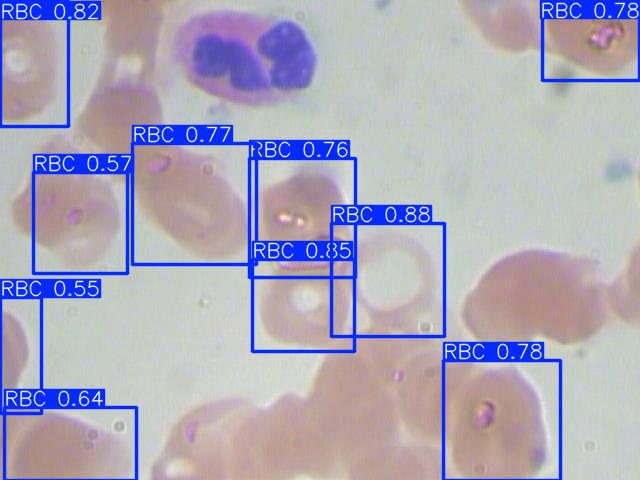

📊 Validation results saved:
   - BoxPR_curve.png
   - confusion_matrix_normalized.png
   - BoxR_curve.png
   - BoxP_curve.png
   - val_batch0_pred.jpg
   - val_batch1_pred.jpg
   - BoxF1_curve.png
   - val_batch2_labels.jpg
   - confusion_matrix.png
   - val_batch2_pred.jpg
   - val_batch1_labels.jpg
   - val_batch0_labels.jpg


In [ ]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

# View prediction results
pred_dir = 'runs/detect/predict'
if os.path.exists(pred_dir):
    print("🖼️ Prediction images saved:")
    for file in os.listdir(pred_dir):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            print(f"   - {file}")
            # Display first few
            display(Image(os.path.join(pred_dir, file)))
            break  # Show just one example

# View validation charts
val_dir = 'runs/detect/val'
if os.path.exists(val_dir):
    print("📊 Validation results saved:")
    for file in os.listdir(val_dir):
        print(f"   - {file}")


In [ ]:
# Malaria Classification with EfficientNet
# This should work smoothly - no complex parsing like BCCD!

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set up GPU if available
gpu_available = tf.config.list_physical_devices('GPU')
print("GPU Available: ", gpu_available)

if not gpu_available:
    print("Warning: No GPU available. Training will be very slow on CPU.")
    print("Please ensure you have selected a GPU runtime (Runtime -> Change runtime type).")


# Dataset paths - UPDATE THESE!
DATASET_PATH = "/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/Malaria Dataset/Dataset"  # Main dataset folder
TRAIN_PATH = os.path.join(DATASET_PATH, "Train")
TEST_PATH = os.path.join(DATASET_PATH, "Test")

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

def check_dataset_structure(dataset_path):
    """Quick check of malaria dataset - should be simple!"""
    print("🔍 Checking dataset structure...")

    for split in ['Train', 'Test']:
        split_path = os.path.join(dataset_path, split)
        if os.path.exists(split_path):
            print(f"\n📊 {split.upper()} SET:")
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    count = len([f for f in os.listdir(class_path)
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"   {class_name}: {count} images")

def create_data_generators(train_path, test_path):
    """Create data generators with augmentation"""

    # Data augmentation for training
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.2  # 20% for validation
    )

    # Only rescaling for test data
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',  # Parasite=1, Uninfected=0
        subset='training'
    )

    # Validation generator
    val_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )

    # Test generator
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False  # Keep order for evaluation
    )

    print(f"✅ Data generators created!")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Classes: {train_generator.class_indices}")

    return train_generator, val_generator, test_generator

def create_efficientnet_model():
    """Create EfficientNet-B2 model for malaria classification"""

    # Load pre-trained EfficientNet-B2
    base_model = tf.keras.applications.EfficientNetB2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid', name='predictions')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    print("✅ EfficientNet-B2 model created!")
    print(f"Total parameters: {model.count_params():,}")

    return model

def train_malaria_classifier():
    """Complete training pipeline"""

    print("🚀 Starting Malaria Classification Training...")

    # 1. Check dataset
    check_dataset_structure(DATASET_PATH)

    # 2. Create data generators
    train_gen, val_gen, test_gen = create_data_generators(TRAIN_PATH, TEST_PATH)

    # 3. Create model
    model = create_efficientnet_model()

    # 4. Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=3,
            min_lr=1e-7
        ),
        keras.callbacks.ModelCheckpoint(
            'best_malaria_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]

    # 5. Train model
    print("\n🔥 Training Phase 1: Transfer Learning...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # 6. Fine-tuning (unfreeze some layers)
    print("\n🔥 Training Phase 2: Fine-tuning...")
    model.layers[0].trainable = True

    # Freeze early layers, unfreeze later ones
    for layer in model.layers[0].layers[:-20]:
        layer.trainable = False

    # Lower learning rate for fine-tuning
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Continue training
    history_fine = model.fit(
        train_gen,
        epochs=10, # Reduced fine-tuning epochs
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    # 7. Evaluate on test set
    print("\n📊 Evaluating on test set...")
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_gen)

    print(f"\n🎯 Final Test Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    if (test_precision + test_recall) > 0:
        print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")
    else:
        print("F1-Score: N/A (Precision + Recall = 0)")


    # 8. Plot training history
    plot_training_history(history, history_fine)

    # 9. Save final model
    model.save('malaria_classifier_final.h5')
    print("✅ Model saved as 'malaria_classifier_final.h5'")

    return model, history

def plot_training_history(history1, history2):
    """Plot training curves"""

    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def test_single_prediction(model_path, image_path):
    """Test model on a single image"""

    model = keras.models.load_model(model_path)

    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Predict
    prediction = model.predict(img_batch)[0][0]

    # Interpret result
    if prediction > 0.5:
        result = f"PARASITE (Infected) - Confidence: {prediction:.3f}"
        color = 'red'
    else:
        result = f"UNINFECTED (Normal) - Confidence: {1-prediction:.3f}"
        color = 'green'

    # Display result
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(result, color=color, fontsize=14, weight='bold')
    plt.axis('off')
    plt.show()

    return prediction

# Usage:
if __name__ == "__main__":
    # Train the model
    model, history = train_malaria_classifier()

    # Test on a single image (optional)
    # test_single_prediction('malaria_classifier_final.h5', 'path_to_test_image.png')

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 Starting Malaria Classification Training...
🔍 Checking dataset structure...

📊 TRAIN SET:
   Uninfected: 196 images
   Parasite: 220 images

📊 TEST SET:
   Uninfected: 43 images
   Parasite: 91 images
Found 333 images belonging to 2 classes.
Found 83 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
✅ Data generators created!
Training samples: 333
Validation samples: 83
Test samples: 134
Classes: {'Parasite': 0, 'Uninfected': 1}
✅ EfficientNet-B2 model created!
Total parameters: 7,949,050

🔥 Training Phase 1: Transfer Learning...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-69-1600019016.py", line 298, in <cell line: 0>

  File "/tmp/ipython-input-69-1600019016.py", line 172, in train_malaria_classifier

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_48418]

In [ ]:
bccd_root = "/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD"
output_root = "/content/BCCD_YOLO"

img_stats, label_stats = convert_bccd_to_yolo(bccd_root, output_root)


Converting test set: 100%|██████████| 72/72 [00:00<00:00, 878.73it/s]


✅ Conversion complete!
Train: 205 images processed, 0 annotated
Val: 87 images processed, 0 annotated
Test: 72 images processed, 0 annotated


In [ ]:
def create_yolo_config(output_root):
    config = {
        'path': output_root,
        'train': os.path.join(output_root, 'images/train'),
        'val': os.path.join(output_root, 'images/val'),
        'test': os.path.join(output_root, 'images/test'),
        'nc': 1,
        'names': ['RBC']
    }

    config_path = os.path.join(output_root, 'rbc_config.yaml')
    with open(config_path, 'w') as f:
        yaml.dump(config, f)

    print(f"✅ Config file created: {config_path}")
    return config_path


In [ ]:
config_path = create_yolo_config(output_root)


✅ Config file created: /content/BCCD_YOLO/rbc_config.yaml


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  # or yolov8n.pt for smaller, faster model

results = model.train(
    data=config_path,
    epochs=50,
    imgsz=640,
    batch=8,
    name="yolov8_rbc",
    project="/content/rbc_detection"
)


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/BCCD_YOLO/rbc_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_rbc5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning /content/BCCD_YOLO/labels/train... 205 images, 205 backgrounds, 0 corrupt: 100%|██████████| 205/205 [00:00<00:00, 4092.18it/s]

train: New cache created: /content/BCCD_YOLO/labels/train.cache
WARNING ⚠️ Labels are missing or empty in /content/BCCD_YOLO/labels/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 548.4±278.6 MB/s, size: 20.8 KB)


val: Scanning /content/BCCD_YOLO/labels/val... 87 images, 87 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 2455.96it/s]

val: New cache created: /content/BCCD_YOLO/labels/val.cache
WARNING ⚠️ Labels are missing or empty in /content/BCCD_YOLO/labels/val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to /content/rbc_detection/yolov8_rbc5/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/rbc_detection/yolov8_rbc5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.12G          0      256.7          0          0        640: 100%|██████████| 26/26 [00:05<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.46G          0      67.58          0          0        640: 100%|██████████| 26/26 [00:04<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.62it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.48G          0      11.92          0          0        640: 100%|██████████| 26/26 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.53G          0      3.919          0          0        640: 100%|██████████| 26/26 [00:04<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.56G          0      1.499          0          0        640: 100%|██████████| 26/26 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.53it/s]


                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.59G          0     0.4093          0          0        640: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.19it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.64G          0     0.1051          0          0        640: 100%|██████████| 26/26 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.67G          0     0.0323          0          0        640: 100%|██████████| 26/26 [00:03<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.59it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.71G          0    0.01062          0          0        640: 100%|██████████| 26/26 [00:04<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 10.11it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.73G          0   0.002072          0          0        640: 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]

                   all         87          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.76G          0  0.0007567          0          0        640:  42%|████▏     | 11/26 [00:02<00:02,  5.36it/s]


KeyboardInterrupt: 

In [ ]:
import os
import yaml

def create_yolo_config(output_root):
    """Create YOLO configuration file"""

    config = {
        'path': output_root,
        'train': os.path.join(output_root, 'images/train'),
        'val': os.path.join(output_root, 'images/val'),
        'test': os.path.join(output_root, 'images/test'),
        'nc': 1,  # number of classes (only RBC for now)
        'names': ['RBC']
    }

    config_path = os.path.join(output_root, 'rbc_config.yaml')
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"✅ Config file created: {config_path}")
    return config_path


In [ ]:
def create_yolo_config(output_root, stats):
    """Create YOLO configuration file"""

    config = {
        'path': output_root,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': 1,  # number of classes (only RBC)
        'names': ['RBC']
    }

    config_path = os.path.join(output_root, 'rbc_config.yaml')
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"Config file created: {config_path}")
    return config_path

def train_yolo_rbc(config_path, model_size='s'):
    """Train YOLO model for RBC detection"""

    # Choose model size: n(nano), s(small), m(medium), l(large), x(xlarge)
    model = YOLO(f'yolov8{model_size}.pt')

    print(f"Starting training with YOLOv8{model_size}...")

    # Train the model - COLAB OPTIMIZED SETTINGS
    results = model.train(
        data=config_path,
        epochs=50,  # Reduced for Colab time limits
        batch=4,    # Smaller batch for Colab GPU memory
        imgsz=640,
        lr0=0.01,
        patience=15,
        save=True,
        device=0 if torch.cuda.is_available() else 'cpu',
        project='/content/rbc_detection',  # Colab path
        name='yolov8_rbc',
        verbose=True
    )

    return model, results

In [ ]:
def evaluate_model(model, test_images_path):
    """Evaluate the trained model"""

    print("Evaluating model...")

    # Run inference on test set
    results = model.predict(
        source=test_images_path,
        save=True,
        conf=0.25,  # Confidence threshold
        project='/content/rbc_detection',  # Colab path
        name='predictions'
    )

    # Print some statistics
    total_images = len(results)
    total_detections = sum(len(r.boxes) if r.boxes is not None else 0 for r in results)

    print(f"Processed {total_images} test images")
    print(f"Total RBC detections: {total_detections}")
    if total_images > 0:
        print(f"Average detections per image: {total_detections/total_images:.2f}")

    return results

In [ ]:
BCCD_ROOT = "/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD"
BCCD_ROOT

'/kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD'

In [ ]:


# Option 2: If data is in Google Drive (uncomment these lines)
# BCCD_ROOT = "/content/drive/MyDrive/BCCD"

# Output will be saved in Colab
YOLO_OUTPUT = "/content/BCCD_YOLO"

# Check if BCCD folder exists
if not os.path.exists(BCCD_ROOT):
    print(f"❌ BCCD folder not found at: {BCCD_ROOT}")
    print("Please upload your BCCD dataset or check the path!")
    print("\nTo upload to Colab:")
    print("1. Click the folder icon on the left")
    print("2. Upload your BCCD folder")
    print("3. Make sure it has train/, test/, val/ folders")
else:
    print(f"✅ Found BCCD dataset at: {BCCD_ROOT}")

    # List contents to verify structure
    contents = os.listdir(BCCD_ROOT)
    print(f"Contents: {contents}")

    # Start the pipeline
    print("\n🚀 Step 1: Converting BCCD to YOLO format...")
    stats = convert_bccd_to_yolo(BCCD_ROOT, YOLO_OUTPUT)

    print("\n📝 Step 2: Creating YOLO config...")
    config_path = create_yolo_config(YOLO_OUTPUT, stats)

    print("\n🎯 Step 3: Starting YOLO training...")
    print("This will take 15-30 minutes depending on your data size...")
    model, training_results = train_yolo_rbc(config_path, model_size='s')

    print("\n📊 Step 4: Evaluating on test set...")
    test_results = evaluate_model(model, os.path.join(YOLO_OUTPUT, "images/test"))

    print("\n✅ Training completed!")
    print("Results saved in: /content/rbc_detection/")

    # Show some predictions
    print("\n🔍 Sample predictions:")
    for i, result in enumerate(test_results[:3]):  # Show first 3 results
        if result.boxes is not None and len(result.boxes) > 0:
            print(f"Image {i+1}: {len(result.boxes)} RBCs detected")
            confidences = result.boxes.conf.cpu().numpy()
            print(f"  Confidence range: {confidences.min():.3f} - {confidences.max():.3f}")
        else:
            print(f"Image {i+1}: No RBCs detected")

    print("\n📁 Check these folders for results:")
    print("- /content/rbc_detection/yolov8_rbc/ (training results)")
    print("- /content/rbc_detection/predictions/ (test predictions)")

✅ Found BCCD dataset at: /kaggle/input/disease-prediction-based-on-blood-test/Deep learning-cells/BCCD
Contents: ['LICENSE.md', 'README.md', 'val', 'meta.json', 'test', 'train']

🚀 Step 1: Converting BCCD to YOLO format...
Converting train set...
Converted 0 images for train set
Converting val set...
Converted 0 images for val set
Converting test set...
Converted 0 images for test set

Conversion complete!
Train: 0 images
Val: 0 images
Test: 0 images

📝 Step 2: Creating YOLO config...
Config file created: /content/BCCD_YOLO/rbc_config.yaml

🎯 Step 3: Starting YOLO training...
This will take 15-30 minutes depending on your data size...
Starting training with YOLOv8s...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, 

FileNotFoundError: [34m[1mtrain: [0mError loading data from /content/BCCD_YOLO/images/train
See https://docs.ultralytics.com/datasets for dataset formatting guidance.